# Home task
### Find the public dataset and apply collaborative filtering recommendation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Functions for future use:

### Collaborative Filtering Cost Function

$$ J =\frac{1}{2}\sum{((X @ \Theta-Y)*R)^2} + \frac{\lambda}{2}\sum{X^2} + \frac{\lambda}{2}\sum{\Theta^2}$$

In [3]:
def J(Y, R, X, Theta, lambd):
    assert (X.shape[1] == Theta.shape[0])
    h = X @ Theta

    try:
        assert (h.shape == Y.shape)
    except:
        print('h.shape {} !=Y.shape {}'.format(h.shape, Y.shape))

    J = 1/2 * np.sum(((h-Y)*R) ** 2) + lambd/2 * \
        np.sum(X**2) + lambd/2 * np.sum(Theta**2)

    try:
        assert (len(J.shape) == 0)
    except:
        print('J is not raw number. J.shape = ', J.shape)

    return J

### Collaborative Filtering Cost Function Gradient

$$\frac{\partial J}{\partial X}=((X @ \Theta-Y)*R) @ \Theta^{T}+ \lambda X, \quad
\frac{\partial J}{\partial \theta}= \left( ((X @ \Theta-Y)*R)^{T} @ X \right)^{T} + \lambda  \Theta $$

In [4]:
def J_derivative(Y, R, X, Theta, lambd):

    cost_matr = (X @ Theta - Y) * R

    X_grad = cost_matr @ Theta.T
    Theta_grad = (cost_matr.T @ X).T

    try:
        assert (X_grad.shape == X.shape)
        assert (Theta_grad.shape == Theta.shape)
    except:
        print('Check gradient calculus')

    X_grad += lambd * X
    Theta_grad += lambd * Theta

    return X_grad, Theta_grad

### Gradient descent (fit)

In [5]:
def fit(Y, R, num_features=10,  alpha=0.0001, lambd=.01, eps=.1,  max_iter=1000, step=100, verbose=0):
    num_movies, num_users = Y.shape

    if verbose:
        print('Running gradient descent with alpha= {}, lambda= {}, eps= {}, max_iter= {}'.format(
            alpha, lambd, eps, max_iter))

    np.random.seed(2019)
    X = np.random.randn(num_movies, num_features)
    Theta = np.random.randn(num_features, num_users)

    J_hist = [-1]
    continue_iter = True
    iter_number = 0

    while continue_iter:

        X_grad, Theta_grad = J_derivative(
            Y, R, X, Theta, lambd)
        X = X - alpha * X_grad
        Theta = Theta - alpha * Theta_grad

        J_hist.append(J(Y, R, X, Theta, lambd))

        if iter_number > max_iter:
            continue_iter = False
            print('iter_number> max_iter')

        elif np.abs(J_hist[iter_number-1] - J_hist[iter_number]) < eps:
            continue_iter = False
            print('J_hist[iter_number]={}'.format(J_hist[iter_number]))
        iter_number += 1

        if verbose and iter_number % step == 0:
            print('{}: {}'.format(iter_number, J_hist[iter_number-1]))

    return X, Theta, J_hist

### Getting a dataset with ratings of mivoes

In [6]:
def Get_ratings():
    df = pd.read_csv('Datasets/ratings.csv')
    
    # Remove an unnecessary column
    df = df.drop('timestamp', axis=1)
    
    return df
    

### Getting a dataset with name movies 

In [22]:
def Get_name_movies():
    df = pd.read_csv('Datasets/movies.csv')
    
    df = df.drop('genres', axis=1)
    df = df.set_index('movieId')
    
    return df

### Converto to a matrix

In [7]:
def Convert_to_matrix(df, values, index, columns):
    df_target = df.pivot_table(values=values, index=index, columns=columns, aggfunc=np.max, dropna= False)
    df_target = df_target.fillna(0)
    
    return df_target

### Getting Y and R

In [8]:
def get_Y_and_R(df):
    Y = df.fillna(0)
    R = df.fillna(0)
    R[R > 0] = 1
    
    return Y, R

### Y scaled

In [9]:
def get_Y_scaled(Y):
    scale = Y.max() - Y.min()
    Y_scaled = Y / scale * 10
    
    return Y_scaled, scale

### Normalisation

In [10]:
def normalize_Y(Y, R, num_movies):
    Y_mean = np.zeros((num_movies, 1))
    Y_norm = np.zeros(Y.shape)

    for i in range(num_movies):
        idx = R[i, :] == 1
        Y_mean[i] = Y[i, idx].mean()
        Y_norm[i, idx] = Y[i, idx] - Y_mean[i]

    return Y_mean, Y_norm

### Cost function

In [11]:
def draw_cost_changes(J_hist):
    J_hist=J_hist[1:]
    plt.figure()
    plt.scatter(np.arange(0,len(J_hist)),J_hist,s=20,marker='.',c='b')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')

# Collaborative Filtering

### Get ratings

In [12]:
df = Get_ratings()
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


### Convert to a matrix

In [13]:
df_target = Convert_to_matrix(df, 'rating', 'movieId', 'userId')
df_target

C:\Users\Admin\AppData\Local\Temp\ipykernel_17712\3213270562.py:2: FutureWarning: The provided callable <function max at 0x0000024237069A20> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_target = df.pivot_table(values=values, index=index, columns=columns, aggfunc=np.max, dropna= False)


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get Y and R

In [14]:
Y, R = get_Y_and_R(df_target)

print('Y.shape=', Y.values.shape)
print('Y[:5] =\n', Y.values[:5])
print('\nUnique values of Y:\n', set(Y.values.ravel()))

print()

print('R.shape=', R.values.shape)
print('R[:5] =\n', R.values[:5])
print('\nUnique values of R:\n', set(R.values.ravel()))

Y.shape= (9724, 610)
Y[:5] =
 [[4.  0.  0.  ... 2.5 3.  5. ]
 [0.  0.  0.  ... 2.  0.  0. ]
 [4.  0.  0.  ... 2.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]

Unique values of Y:
 {0.0, 0.5, 2.5, 3.5, 4.0, 4.5, 3.0, 5.0, 2.0, 1.5, 1.0}

R.shape= (9724, 610)
R[:5] =
 [[1. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Unique values of R:
 {0.0, 1.0}


#### Y scaled

In [15]:
Y_scaled, scale = get_Y_scaled(Y)
Y_scaled

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,8.0,0.0,0.0,0.0,8.0,0.0,9.0,0.0,0.0,0.0,...,8.0,0.0,8.0,6.0,8.0,5.0,8.0,5.0,7.5,10.0
2,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,0.0,...,0.0,8.0,0.0,10.0,7.0,0.0,0.0,4.0,0.0,0.0
3,8.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalisation

In [16]:
Y_mean, Y_norm = normalize_Y(Y_scaled.values, R.values, Y_scaled.shape[0])

Y_mean

array([[7.89612403],
       [6.88383838],
       [6.51923077],
       ...,
       [7.        ],
       [7.        ],
       [8.        ]])

In [17]:
Y_norm

array([[ 0.10387597,  0.        ,  0.        , ..., -2.89612403,
        -0.39612403,  2.10387597],
       [ 0.        ,  0.        ,  0.        , ..., -2.88383838,
         0.        ,  0.        ],
       [ 1.48076923,  0.        ,  0.        , ..., -2.51923077,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Train model

In [18]:
X, Theta, J_hist = fit(Y_norm, R.values, num_features=20, alpha=0.0005, lambd=1, max_iter=2500,
                           eps=.01, step=50, verbose=1)

Running gradient descent with alpha= 0.0005, lambda= 1, eps= 0.01, max_iter= 2500
50: 232486.36338635217
100: 210834.17345363705
150: 195962.78646385923
200: 183334.23806405513
250: 172356.35998468855
300: 162642.81450568908
350: 153921.2745300508
400: 146007.77375882838
450: 138768.35883361526
500: 132097.0396668023
550: 125910.26668762065
600: 120145.84762082972
650: 114760.39682300425
700: 109724.7967898831
750: 105018.79080854221
800: 100625.94113519223
850: 96529.95318723793
900: 92712.88050420003
950: 89155.04129853038
1000: 85835.96019921744
1050: 82735.57914320251
1100: 79835.24346565022
1150: 77118.27960072931
1200: 74570.18306876953
1250: 72178.52136664536
1300: 69932.66980219189
1350: 67823.47895206556
1400: 65842.94351855115
1450: 63983.91382683727
1500: 62239.866524974204
1550: 60604.73256178916
1600: 59072.770383509545
1650: 57638.47072011531
1700: 56296.48364322669
1750: 55041.56458187338
1800: 53868.54028042857
1850: 52772.296849023536
1900: 51747.79037365197
1950: 5079

### Cost function

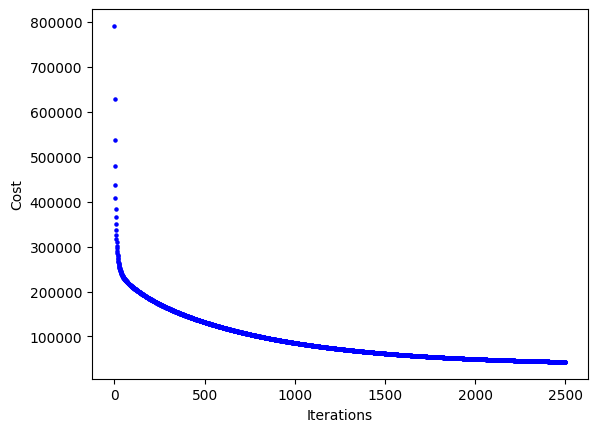

In [19]:
draw_cost_changes(J_hist)

### Predict

In [23]:
pred = X @ Theta
my_pred = pred[:,0]

print(my_pred.shape)

top_pred = np.argsort(my_pred)[::-1]
print('\nTop recommendations for you:\n')

name_movies = Get_name_movies()

for i in range(100):
    j = top_pred[i]
    print('Predicting rating {:.2} for movie {} (# {})\n'.format(
        my_pred[j], name_movies.iloc[j], j))

(9724,)

Top recommendations for you:

Predicting rating 7.6 for movie title    Diabolique (1996)
Name: 640, dtype: object (# 543)

Predicting rating 7.5 for movie title    Free Willy 2: The Adventure Home (1995)
Name: 169, dtype: object (# 141)

Predicting rating 7.0 for movie title    Much Ado About Nothing (1993)
Name: 497, dtype: object (# 434)

Predicting rating 6.9 for movie title    Mighty Morphin Power Rangers: The Movie (1995)
Name: 181, dtype: object (# 153)

Predicting rating 6.7 for movie title    King of California (2007)
Name: 55729, dtype: object (# 6608)

Predicting rating 6.7 for movie title    Six-String Samurai (1998)
Name: 2275, dtype: object (# 1692)

Predicting rating 6.5 for movie title    Adventures of Priscilla, Queen of the Desert, ...
Name: 345, dtype: object (# 303)

Predicting rating 6.4 for movie title    Nell (1994)
Name: 282, dtype: object (# 244)

Predicting rating 6.4 for movie title    Remains of the Day, The (1993)
Name: 515, dtype: object (# 450)

P

In [36]:
pred_rescaled = (pred + Y_mean) * scale.values / 10
pred_rescaled

array([[4.95203323, 4.24036718, 2.06265028, ..., 2.65380834, 3.21453845,
        4.60851587],
       [3.26320181, 3.4402097 , 1.99171924, ..., 1.98915425, 3.11100944,
        3.72457116],
       [4.06492531, 2.72135892, 2.10986529, ..., 2.12565457, 3.07909224,
        2.79471482],
       ...,
       [4.58518725, 4.40357662, 3.45933296, ..., 2.63981085, 3.30744729,
        3.90028032],
       [4.3704986 , 3.34182728, 4.32933528, ..., 3.6233666 , 3.01321985,
        3.62098692],
       [5.00274869, 4.25385844, 3.24520803, ..., 2.40316281, 3.66686985,
        4.3202125 ]])

### Convert back from pivot to sparse format

In [27]:
df_results_pivot = pd.DataFrame(pred_rescaled, index=Y.index, columns=Y.columns)

df_results_pivot_temp = pd.DataFrame(df_results_pivot.to_records())
df_results = pd.melt(df_results_pivot_temp,
                     id_vars='movieId',
                     value_vars=list(df_results_pivot_temp.columns[1:]),
                     var_name='userId',
                     value_name='rating_pred')
df_results

,movieId,userId,rating_pred
0,1,1,4.952033
1,2,1,3.263202
2,3,1,4.064925
3,4,1,0.595287
4,5,1,3.041593
...,...,...,...
5931635,193581,610,4.094261
5931636,193583,610,3.444446
5931637,193585,610,3.900280
5931638,193587,610,3.620987


### Round to existing values

In [29]:
existing_unique_values = np.array(sorted(df['rating'].unique()))

def round_to_existing(val):
    return existing_unique_values[np.argmin(np.abs(existing_unique_values-val))]

df_results['rating_round'] = df_results['rating_pred'].apply(round_to_existing)
df_results

,movieId,userId,rating_pred,rating_round
0,1,1,4.952033,5.0
1,2,1,3.263202,3.5
2,3,1,4.064925,4.0
3,4,1,0.595287,0.5
4,5,1,3.041593,3.0
...,...,...,...,...
5931635,193581,610,4.094261,4.0
5931636,193583,610,3.444446,3.5
5931637,193585,610,3.900280,4.0
5931638,193587,610,3.620987,3.5


In [31]:
df_results['userId'] = df_results['userId'].astype(int)
df_eval = df.merge(df_results, on=['userId', 'movieId'])
df_eval

,userId,movieId,rating,rating_pred,rating_round
0,1,1,4.0,4.952033,5.0
1,1,3,4.0,4.064925,4.0
2,1,6,4.0,3.944716,4.0
3,1,47,5.0,5.187705,5.0
4,1,50,5.0,4.722495,4.5
...,...,...,...,...,...
100831,610,166534,4.0,4.026292,4.0
100832,610,168248,5.0,4.880683,5.0
100833,610,168250,5.0,4.449075,4.5
100834,610,168252,5.0,5.217573,5.0


In [32]:
from sklearn.metrics import r2_score

0.8761559839080574
mean error = 0.2541686689257901, max error = 3.4692458822438836


<Axes: >

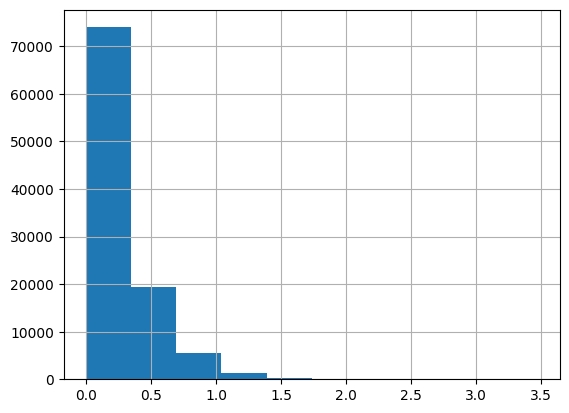

In [33]:
print(r2_score(df_eval['rating'], df_eval['rating_pred']))

df_eval['diff'] = df_eval['rating'] - df_eval['rating_pred']
df_eval['diff'] = df_eval['diff'].apply(np.abs)
print('mean error = {}, max error = {}'.format(
    df_eval['diff'].mean(), df_eval['diff'].max()))
df_eval['diff'].hist()

0.8648902725311011
mean error = 0.21823059224880004, max error = 3.5


<Axes: >

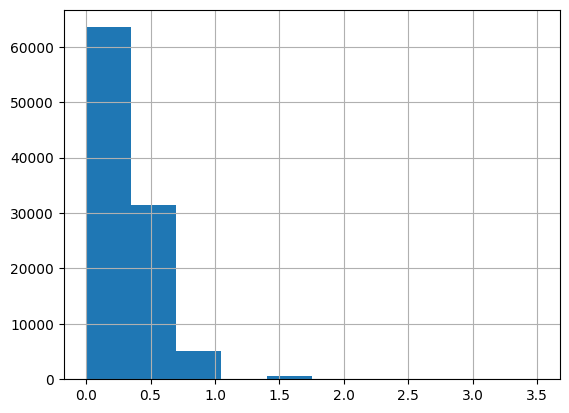

In [37]:
print(r2_score(df_eval['rating'], df_eval['rating_round']))
df_eval['diff'] = df_eval['rating'] - df_eval['rating_round']
df_eval['diff'] = df_eval['diff'].apply(np.abs)
print('mean error = {}, max error = {}'.format(
    df_eval['diff'].mean(), df_eval['diff'].max()))
df_eval['diff'].hist()

### Evaluate cofi on test set

In [39]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=1000)
df_train.shape, df_test.shape

((99836, 3), (1000, 3))

C:\Users\Admin\AppData\Local\Temp\ipykernel_17712\3213270562.py:2: FutureWarning: The provided callable <function max at 0x0000024237069A20> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_target = df.pivot_table(values=values, index=index, columns=columns, aggfunc=np.max, dropna= False)


Running gradient descent with alpha= 0.0005, lambda= 1, eps= 0.01, max_iter= 3000
50: 230550.86487896828
100: 208365.7328835936
150: 193159.06097607836
200: 180639.7496194137
250: 169884.19961910183
300: 160394.90073707062
350: 151873.79059369222
400: 144129.04432008497
450: 137027.3150022594
500: 130470.2758549945
550: 124384.80123533972
600: 118717.28435003982
650: 113428.5328571882
700: 108489.05652291098
750: 103875.17637356053
800: 99566.26028593037
850: 95543.11991976736
900: 91787.3042197582
950: 88280.89128841444
1000: 85006.47078975322
1050: 81947.18444909359
1100: 79086.81042571556
1150: 76409.90599112182
1200: 73902.00142562311
1250: 71549.81012765518
1300: 69341.4070007839
1350: 67266.33197656512
1400: 65315.59233431162
1450: 63481.55884280453
1500: 61757.77045622886
1550: 60138.67642579464
1600: 58619.35179582147
1650: 57195.222819274364
1700: 55861.834149772665
1750: 54614.68092512118
1800: 53449.117101088996
1850: 52360.3382650754
1900: 51343.42527271873
1950: 50393.4272

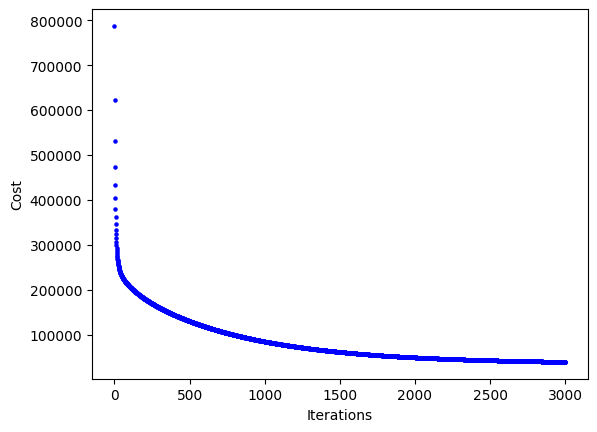

In [40]:
df_target = Convert_to_matrix(df_train, 'rating','movieId', 'userId')

Y, R = get_Y_and_R(df_target)

Y_scaled, scale = get_Y_scaled(Y)

Y_mean, Y_norm = normalize_Y(Y_scaled.values, R.values, Y_scaled.shape[0])

X, Theta, J_hist = fit(Y_norm, R.values, num_features=20, alpha=0.0005, lambd=1, max_iter=3000,
                       eps=.01, step=50, verbose=1)
draw_cost_changes(J_hist)

In [41]:
pred = X @ Theta

pred_rescaled = (pred + Y_mean) * scale.values / 10
pred_rescaled

df_results_pivot = pd.DataFrame(pred_rescaled, index=Y.index, columns=Y.columns)

df_results_pivot_temp = pd.DataFrame(df_results_pivot.to_records())
df_results = pd.melt(df_results_pivot_temp,
                     id_vars='movieId',
                     value_vars=list(df_results_pivot_temp.columns[1:]),
                     var_name='userId',
                     value_name='rating_pred')
df_results

,movieId,userId,rating_pred
0,1,1,5.115799
1,2,1,4.231932
2,3,1,4.390177
3,4,1,2.098814
4,5,1,3.763356
...,...,...,...
5912725,193581,610,3.773022
5912726,193583,610,3.325393
5912727,193585,610,3.420959
5912728,193587,610,3.199559


### Evaluate on train set

In [42]:
df_results['userId']= df_results['userId'].astype(int)
df_eval= df_train.merge(df_results, on=['userId','movieId'])

r2_score= 0.8826500319139894
mean error = 0.24440918708895176, max error = 2.9327331341383998


<Axes: >

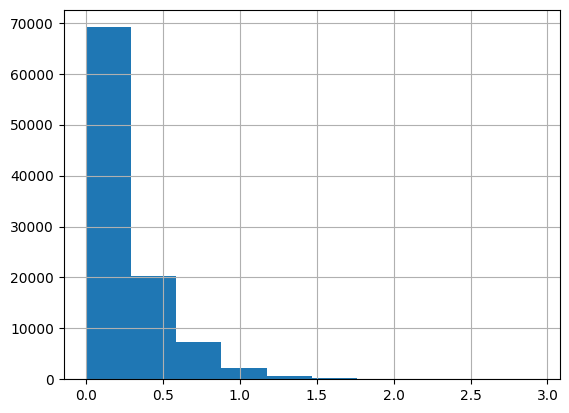

In [43]:
print ('r2_score=', r2_score(df_eval['rating'], df_eval['rating_pred'])  )
df_eval['diff'] = df_eval['rating']- df_eval['rating_pred']

df_eval['diff']= df_eval['diff'].apply(np.abs)
print ('mean error = {}, max error = {}'.format(df_eval['diff'].mean(), df_eval['diff'].max()) )
df_eval['diff'].hist()

### Evaluate on test set

In [44]:
df_results['userId']= df_results['userId'].astype(int)
df_eval= df_test.merge(df_results, on=['userId','movieId'])
df_eval 

,userId,movieId,rating,rating_pred
0,377,56176,0.5,1.920294
1,465,3699,4.0,3.032533
2,605,3988,3.0,1.439915
3,260,6331,4.5,2.996487
4,187,380,2.0,2.616125
...,...,...,...,...
964,590,3039,3.0,3.766808
965,346,6643,4.0,2.663934
966,274,4732,1.5,1.629559
967,573,1377,4.0,4.058115


r2_score= -0.10876046178687182
mean error = 0.8192408447375691, max error = 6.164142730834115


<Axes: >

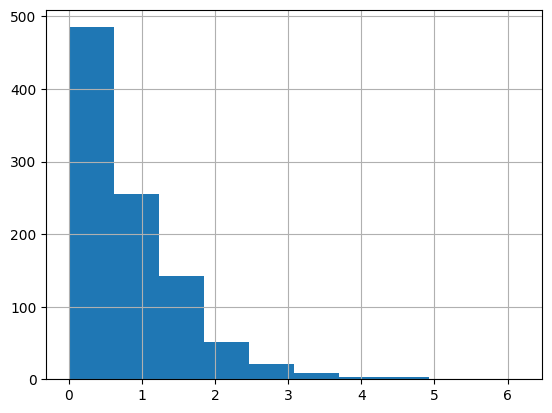

In [45]:
print ('r2_score=', r2_score(df_eval['rating'], df_eval['rating_pred'])  )
df_eval['diff'] = df_eval['rating']- df_eval['rating_pred']

df_eval['diff']= df_eval['diff'].apply(np.abs)
print ('mean error = {}, max error = {}'.format(df_eval['diff'].mean(), df_eval['diff'].max()) )
df_eval['diff'].hist()

In [46]:
print ('r2_score=', r2_score(df_eval['rating'], df_eval['rating_pred'])  )

r2_score= -0.10876046178687182


r2_score= -0.05572751314463398
mean error = 0.7910216718266254, max error = 4.5


<Axes: >

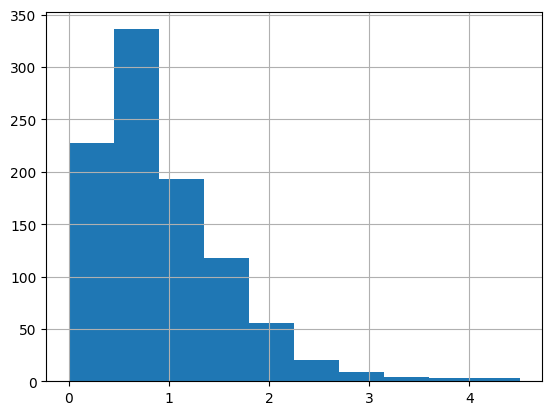

In [48]:
df_results['rating_round']= df_results['rating_pred'].apply(round_to_existing)
df_eval= df_test.merge(df_results, on=['userId','movieId'])
print ('r2_score=', r2_score(df_eval['rating'], df_eval['rating_round'])  )
df_eval['diff'] = df_eval['rating']- df_eval['rating_round']

df_eval['diff']= df_eval['diff'].apply(np.abs)
print ('mean error = {}, max error = {}'.format(df_eval['diff'].mean(), df_eval['diff'].max()) )
df_eval['diff'].hist()